In [1]:
    import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
import numpy as np

#always remember your magic function if using Jupyter
%matplotlib inline

%pylab inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
os.chdir('/Users/alexandrejacqueline/Data_Science/P4')

data_2015 = pd.read_csv('2015-building-energy-benchmarking.csv', sep=',')
data_2016 = pd.read_csv('2016-building-energy-benchmarking.csv', sep=',')


Populating the interactive namespace from numpy and matplotlib


#Projet 4

Anticipez les besoins en consommation électrique de bâtiments

Contexte

Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation. Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Les données de consommation sont à télécharger à cette adresse
Le score Star Energy est consultable ici
La description des variables est consultable sur le site de Seattle


Plan du notebook

1. Adaptation et nettoyage des données

    Import et fonctions
    
    Aperçu des fichiers
    
    Décompactage des données de localisation de 2015
    
    Description et nettoyage des données
    
    1.4.1 Supppression des données d'habitations
    
    1.4.2 Observations sur les colonnes
    
    1.4.3 Valeurs négatives
    
    1.4.4 Outliers
    
    1.4.5 NaNs
    
    1.4.6 Catégorisation et regroupements

2. Analyse exploratoire & Feature Engineering

    Explorations
    
    2.1.1 Les types de bâtiments
    
    2.1.2 Les années de construction
    
    2.1.3 Distributions
    
    Analyse les variables à prédire


In [2]:
data_2015.dtypes


OSEBuildingID                                                      int64
DataYear                                                           int64
BuildingType                                                      object
PrimaryPropertyType                                               object
PropertyName                                                      object
TaxParcelIdentificationNumber                                     object
Location                                                          object
CouncilDistrictCode                                                int64
Neighborhood                                                      object
YearBuilt                                                          int64
NumberofBuildings                                                  int64
NumberofFloors                                                   float64
PropertyGFATotal                                                   int64
PropertyGFAParking                                 

In [3]:
data_2016.shape

(3376, 46)

In [4]:
def count_words(df, colonne):
    list_words = set()
    for word in df[colonne].str.split(','):
        if isinstance(word, float): continue
        list_words = set().union(word, list_words)       
    print("Nb of categories in '{}': {}".format(colonne, len(list_words)))
    return list(list_words)

# calcul du taux de remplissage
def filling_factor(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = (df.shape[0]-missing_df['missing_count'])/df.shape[0]*100
    missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
    return missing_df



In [5]:
print('Python Version: ' + sys.version)
print('Matplotlib Version: ' + mpl.__version__)
print('NumPy Version: ' + np.version.full_version)

Python Version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Matplotlib Version: 3.1.1
NumPy Version: 1.19.5


Vérifions tout d'abord si nous avons les mêmes colonnes dans les 2 datasets

In [6]:
list_1 = list(data_2015.columns) 
list_2 = list(data_2016.columns)

def comp_col(list_1, list_2):
      return list_1 == list_2

print(comp_col(list_1, list_2))

False


In [7]:
#Columns in both 2015 and 2016
set(data_2015.columns).intersection(set(data_2016.columns))

{'BuildingType',
 'ComplianceStatus',
 'CouncilDistrictCode',
 'DataYear',
 'DefaultData',
 'ENERGYSTARScore',
 'Electricity(kBtu)',
 'Electricity(kWh)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'ListOfAllPropertyUseTypes',
 'NaturalGas(kBtu)',
 'NaturalGas(therms)',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'OSEBuildingID',
 'Outlier',
 'PrimaryPropertyType',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'PropertyName',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SteamUse(kBtu)',
 'TaxParcelIdentificationNumber',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearBuilt',
 'YearsENERGYSTARCertified'}

In [8]:
#Columns in 2015 and not 2016
data_2015.columns.difference(data_2016.columns)

Index(['2010 Census Tracts', 'City Council Districts', 'Comment',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'Location', 'OtherFuelUse(kBtu)', 'SPD Beats',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'Zip Codes'],
      dtype='object')

In [9]:
#Columns in 2016 and not 2015
data_2016.columns.difference(data_2015.columns)

Index(['Address', 'City', 'Comments', 'GHGEmissionsIntensity', 'Latitude',
       'Longitude', 'State', 'TotalGHGEmissions', 'ZipCode'],
      dtype='object')

In [10]:
def comp_col(list_1, list_2):
        dif_list_1_list_2 = list(set(list_1) - set(list_2))
        dif_list_2_list_1 = list(set(list_2) - set(list_1))
        return dif_list_1_list_2 , dif_list_2_list_1

print("Les colonnes présentes dans le fichier 2015 et absentes du fichier 2016 sont :")
comp_col(list_1, list_2)[0]

Les colonnes présentes dans le fichier 2015 et absentes du fichier 2016 sont :


['GHGEmissions(MetricTonsCO2e)',
 'OtherFuelUse(kBtu)',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Comment',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Zip Codes',
 'Location',
 '2010 Census Tracts']

In [11]:
print("Les colonnes présentes dans le fichier 2016 et absentes du fichier 2015 sont :")
comp_col(list_1, list_2)[1]

Les colonnes présentes dans le fichier 2016 et absentes du fichier 2015 sont :


['Longitude',
 'Comments',
 'Latitude',
 'TotalGHGEmissions',
 'ZipCode',
 'State',
 'Address',
 'GHGEmissionsIntensity',
 'City']



3. Ajustement des données de localisation de 2015

Les données de localisation sont différentes dans les fichiers 2015 et 2016. Regardons ce que contient la variable 'Location' du set 2015 :


In [12]:
data_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'



Cette variable contient toutes les données de localisation qui sont présentes dans des variables différentiées en 2016.
Nous allons séparer ces variables pour extraire les variables imbriquées :


In [13]:
import ast
data_2015['Location'] = [ast.literal_eval(str(item)) for index, item in data_2015.Location.iteritems()]
data_2015 = pd.concat([data_2015.drop(['Location'], axis=1), data_2015['Location'].apply(pd.Series)], axis=1)
data_2015['human_address'] = [ast.literal_eval(str(item)) for index, item in data_2015.human_address.iteritems()]
data_2015 = pd.concat([data_2015.drop(['human_address'], axis=1), data_2015['human_address'].apply(pd.Series)], axis=1)
data_2015.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  CouncilDistrictCode  \
0   MAYFLOWER PARK HOTEL                     659000030                    7   
1        PARAMOUNT HOTEL                     659000220                    7   
2           WESTIN HOTEL                     659000475                    7   
3              HOTEL MAX                     659000640                    7   
4  WARWICK SEATTLE HOTEL                     659000970                    7   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1            12.0   
1     DOWNTOWN       1996                  1            11.0   
2     DOWNTOWN       1969                  1            41.0   
3     DOWNTOWN       1926                  1            10.0   
4     DOWNTOWN       1980                  1            18.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   
3             61320                   0                   61320   
4            119890               12460                  107430   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2  Hotel, Parking, Swimming Pool                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   757243.0                      Parking   
3                    61320.0                          NaN   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   
1                          15064.0                  Restaurant   
2                         100000.0               Swimming Pool   
3                              NaN                         NaN   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             65.0   
1                          4622.0                      NaN             51.0   
2                             0.0                      NaN             18.0   
3                             NaN                      NaN              1.0   
4                             0.0                      NaN             67.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              78.9                80.3               173.5   
1              94.4                99.0               191.3   
2              96.6                99.7               242.7   
3             460.4               462.5               636.3   
4             120.1               122.1               228.8   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                 175.1            6981428.0              7097539.0   
1                 195.2            8354235.0              8765788.0   
2                 246.5           73130656.0             75506272.0   
3                 643.2           28229320.0             28363444.0   
4              



Nous renommons les nouvelles colonnes afin qu'elles coincident avec celles de 2016 :


In [14]:


data_2015 = data_2015.rename(columns={"latitude":"Latitude", 
                                  "longitude":"Longitude",
                                  "address":"Address", 
                                  "city":"City", 
                                  "state":"State", 
                                  "zip":"ZipCode"})





Regardons les variables qui semblent identiques, à savoir :

    - GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity
    
    - GHGEmissions(MetricTonsCO2e) et TotalGHGEmissions



In [15]:
print(f"Description de la variable GHGEmissions(MetricTonsCO2e) 2015 : \n\n",
      data_2015['GHGEmissions(MetricTonsCO2e)'].describe(),
      f"\n\nDescription de la variable TotalGHGEmissions 2016 : \n\n", 
      data_2016['TotalGHGEmissions'].describe(),
      f"\n\nDescription de la variable GHGEmissionsIntensity(kgCO2e/ft2) 2015 : \n\n", 
      data_2015['GHGEmissionsIntensity(kgCO2e/ft2)'].describe(),
      f"\n\nDescription de la variable GHGEmissionsIntensity 2016 : \n\n", 
      data_2016['GHGEmissionsIntensity'].describe(),
      )


Description de la variable GHGEmissions(MetricTonsCO2e) 2015 : 

 count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64 

Description de la variable TotalGHGEmissions 2016 : 

 count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64 

Description de la variable GHGEmissionsIntensity(kgCO2e/ft2) 2015 : 

 count    3330.000000
mean        0.985339
std         1.637172
min         0.000000
25%         0.080000
50%         0.460000
75%         1.180000
max        31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64 

Description de la variable GHGEmissionsIntensity 2016 : 

 count    3367.000000
mean        1.175916
std         1.821452
min        -0



Ces 4 variables sont du même ordre de grandeur deux à deux : nous allons les renommer à l'identique. Nous supprimerons également les colonnes qui ne sont pas communes aux deux sets.


In [16]:


data_2015 = data_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',
                                  'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
                                  'Comment':'Comments'})
data_2015.drop(['OtherFuelUse(kBtu)','2010 Census Tracts',
              'Seattle Police Department Micro Community Policing Plan Areas',
              'City Council Districts','SPD Beats', 
              'Zip Codes'], axis=1, inplace=True)



In [17]:
list_1 = list(data_2015.columns) 
list_2 = list(data_2016.columns)
comp_col(list_1, list_2)

([], [])

Vérifions si les types sont identiques entre 2015 et 2016.


In [18]:
pd.DataFrame([data_2015.dtypes, data_2016.dtypes])

OSEBuildingID DataYear BuildingType PrimaryPropertyType PropertyName  \
0         int64    int64       object              object       object   
1         int64    int64       object              object       object   

  TaxParcelIdentificationNumber CouncilDistrictCode Neighborhood YearBuilt  \
0                        object               int64       object     int64   
1                        object               int64       object     int64   

  NumberofBuildings NumberofFloors PropertyGFATotal PropertyGFAParking  \
0             int64        float64            int64              int64   
1           float64          int64            int64              int64   

  PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                  int64                    object                 object   
1                  int64                    object                 object   

  LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                   float64                       object   
1                   float64                       object   

  SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                         float64                      object   
1                         float64                      object   

  ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified ENERGYSTARScore  \
0                        float64                   object         float64   
1                        float64                   object         float64   

  SiteEUI(kBtu/sf) SiteEUIWN(kBtu/sf) SourceEUI(kBtu/sf) SourceEUIWN(kBtu/sf)  \
0          float64            float64            float64              float64   
1          float64            float64            float64              float64   

  SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu) SteamUse(kBtu) Electricity(kWh)  \
0             float64               float64        float64          float64   
1             float64               float64        float64          float64   

  Electricity(kBtu) NaturalGas(therms) NaturalGas(kBtu) TotalGHGEmissions  \
0           float64            float64          float64           float64   
1           float64            float64          float64           float64   

  GHGEmissionsIntensity DefaultData Comments ComplianceStatus Outlier  \
0               float64      object   object           object  object   
1               float64        bool  float64           object  object   

  Latitude Longitude Address    City   State  ZipCode  
0   object    object  object  object  object   object  
1  float64   float64  object  object  object  float64

In [19]:


data_2015[['Latitude','Longitude', 'ZipCode']] = data_2015[['Latitude','Longitude', 'ZipCode']].astype('float64')





Les deux sets 2015 et 2016 sont maintenant identiques et nous allons les regrouper dans un unique jeu de données :


In [20]:
df = pd.concat([data_2015[data_2016.columns],data_2016], axis = 0).sort_values(["DataYear", "OSEBuildingID"])
df.shape

(6716, 46)

Selection des observations conformes

La variables ComplianceStatus informe sur la conformité des observations.
On peut alors sélectionner uniquement les observations conformes grâce à cette variable.

In [22]:
print(df['ComplianceStatus'].value_counts(dropna=False))

Compliant                       6548
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Not Compliant                      3
Name: ComplianceStatus, dtype: int64


In [24]:
df = df[df['ComplianceStatus'] == "Compliant"]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6548 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6548 non-null   int64  
 1   DataYear                         6548 non-null   int64  
 2   BuildingType                     6548 non-null   object 
 3   PrimaryPropertyType              6548 non-null   object 
 4   PropertyName                     6548 non-null   object 
 5   Address                          6548 non-null   object 
 6   City                             6548 non-null   object 
 7   State                            6548 non-null   object 
 8   ZipCode                          6535 non-null   float64
 9   TaxParcelIdentificationNumber    6546 non-null   object 
 10  CouncilDistrictCode              6548 non-null   int64  
 11  Neighborhood                     6548 non-null   object 
 12  Latitude            



4. Description et nettoyage des données.

Il est précisié dans le projet que seuls les bâtiments non destinés à l'habitation seront étudiés. Nous allons donc supprimer toutes les lignes correspondant à des habitations en nous basant sur la variable BuildingType.

4.1 Supppression des données d'habitations


In [26]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [27]:
df = df[~df['BuildingType'].str.contains("Multifamily")]
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [28]:
df.shape

(3198, 46)



4.2 Observations sur les colonnes

Analysons les données uniques des colonnes


In [29]:


for column in df.columns:
    if df[column].nunique()<20:
        print('Colonne {}, valeurs uniques :\n{}\n'.format(column, df[column].unique()))
    else:
        print('Colonne {}, {} valeurs uniques'.format(column, df[column].nunique()))



Colonne OSEBuildingID, 1695 valeurs uniques
Colonne DataYear, valeurs uniques :
[2015 2016]

Colonne BuildingType, valeurs uniques :
['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus'
 'Nonresidential WA']

Colonne PrimaryPropertyType, 29 valeurs uniques
Colonne PropertyName, 3085 valeurs uniques
Colonne Address, 3001 valeurs uniques
Colonne City, valeurs uniques :
['SEATTLE' 'Seattle']

Colonne State, valeurs uniques :
['WA']

Colonne ZipCode, 48 valeurs uniques
Colonne TaxParcelIdentificationNumber, 1818 valeurs uniques
Colonne CouncilDistrictCode, valeurs uniques :
[7 3 2 4 5 6 1]

Colonne Neighborhood, valeurs uniques :
['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'CENTRAL' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'SOUTHWEST' 'DELRIDGE' 'North' 'Delridge' 'Ballard'
 'Northwest' 'Central' 'DELRIDGE NEIGHBORHOODS']

Colonne Latitude, 2967 valeurs uniques
Colonne Longitude, 2868 valeurs uniques
Colonne YearBuilt, 113 valeur

Explication des variables
Plusieurs variables concernent les surfaces (GFA = Gross floor area) :

    Gross floor area : surface totale
    PropertyGFAParking : surface des parkings
    PropertyGFABuilding(s) : surface des bâtiments
    ListOfAllPropertyUseTypes : les différentes utilisations des surfaces (Hotel, Parking, Restaurant, Piscine, etc.)
    LargestPropertyUseType / LargestPropertyUseTypeGFA : principale destination du bâtiment et sa surface
    SecondLargestPropertyUseType / SecondLargestPropertyUseTypeGFA : seconde destination du bâtiment et sa surface
    ThirdLargestPropertyUseType / ThirdLargestPropertyUseTypeGFA : troisième destination du bâtiment et sa surface

Concernant l'énergie, ENERGY STAR nous indique :

    SiteEUI(kBtu/sf) / SiteEUIWN(kBtu/sf) : Energy Use Intensity (EUI) ou intensité de la consommation d'énergie ; l'EUI exprime la consommation d'énergie d'un bâtiment en fonction de sa taille ou d'autres caractéristiques.
    SourceEUI(kBtu/sf) SourceEUIWN(kBtu/sf) : la source d'énergie est l'unité d'évaluation la plus équitable pour comparer différents bâtiments entre eux. La source d'énergie représente la quantité totale de combustible brut nécessaire au fonctionnement du bâtiment. Il intègre toutes les pertes de transmission, de livraison et de production. En prenant en compte toutes les consommations d'énergie, le score fournit une évaluation complète de l'efficacité énergétique d'un bâtiment.

SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu) SteamUse(kBtu) Electricity(kWh) Electricity(kBtu) NaturalGas(therms) NaturalGas(kBtu) : l'utilisation des énergies est exprimée en diverses unités :

    kBTu : le B.T.U. (British Thermal Unit) est une unité de mesure d'énergie thermique. Le BTU, de symbole Btu, est utilisé dans les pays anglo-saxons et asiatiques et équivaut à 1055,06 Joule ou 252 calories.
    1 BTU est l’énergie nécessaire pour chauffer ou refroidir une livre d’eau de 1 degré Fahrenheit au niveau de la mer.
    Pour convertir une puissance en Btu une puissance en watt il suffit de diviser la puissance en Btu par 3414,5 pour obtenir la puissance en Kw.

    therms : le therm est une unité d'énergie thermique anglo-saxone égale à 1 000 000 unités thermiques britanniques (BTU).

        1 kWh = 0.034095106405145 thm
        1 thm = 29.329722222222 kWh

Supprimons les colonnes qui ne nous intéressent pas dans ce projet :

State (une seule valeur) Comments les variables qui se terminent par WN (Weather Normalized) qui sont des corrections des conditions climatiques. D'autres variables sont redondantes :

Electricity(kWh) / Electricity(kBtu) NaturalGas(therms) / NaturalGas(kBtu)


In [30]:
df.shape

(3198, 46)

In [31]:
def search_componant(df, suffix=None):
        componant = []
        for col in df.columns:
            if suffix in col: 
                componant.append(col)
        return componant

In [32]:
# suppressions des variables qui ne nous intéressent pas
df.drop(['State','Comments','ZipCode','City'], axis=1, inplace=True)

In [33]:
df.shape

(3198, 42)

In [34]:
#Suppression des variables avec suffixe WN
df.drop(search_componant(df,'WN'), axis=1, inplace=True)


In [35]:
df.shape

(3198, 39)

In [36]:


#Suppression des variables redondantes
redundant_features = ['NaturalGas(therms)','Electricity(kWh)']
df.drop(redundant_features, axis=1, inplace=True)





Mettons à jour quelques valeurs dans les variables uniques:


In [37]:
df.shape

(3198, 37)

In [38]:
df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
df['Neighborhood']=df['Neighborhood'].map(lambda x: x.upper())



In [39]:
df.shape

(3198, 37)

In [40]:
df['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE'], dtype=object)

In [41]:


df['ComplianceStatus'].replace('Missing Data', np.nan, inplace=True)
df['ComplianceStatus'].replace('Error - Correct Default Data', np.nan, inplace=True)



In [42]:
df.shape

(3198, 37)

4.3 Vérification des valeurs négatives

In [43]:
df.min()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


OSEBuildingID                                       1
DataYear                                         2015
BuildingType                                   Campus
PrimaryPropertyType                College/University
PropertyName                         #4706 Bitterlake
Address                                10 HARRISON ST
CouncilDistrictCode                                 1
Neighborhood                                  BALLARD
Latitude                                    47.499331
Longitude                                  -122.41182
YearBuilt                                        1900
NumberofBuildings                                 0.0
NumberofFloors                                    0.0
PropertyGFATotal                                11285
PropertyGFAParking                                 -2
PropertyGFABuilding(s)                         -50550
LargestPropertyUseTypeGFA                      5656.0
SecondLargestPropertyUseTypeGFA                   0.0
ThirdLargestPropertyUseTypeG

Nous avons des valeurs négatives pour les variables PropertyGFAParking et PropertyGFABuilding(s). 

Regardons :

In [44]:
df[df['PropertyGFAParking']<0]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
3136          29551      2015  NonResidential  Small- and Mid-Sized Office   

       PropertyName        Address TaxParcelIdentificationNumber  \
3136  625 5TH AVE S  625 5TH AVE S                    8809700040   

      CouncilDistrictCode Neighborhood   Latitude   Longitude  YearBuilt  \
3136                    2     DOWNTOWN  47.597252 -122.327747       2000   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3136                1.0            11.0             68452                  -2   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
3136                   68454       Bank Branch, Office                 Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3136                    61665.0                  Bank Branch   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3136                           6787.0                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
3136                             NaN               2016, 2015   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  \
3136             81.0              53.6               168.4   

      SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
3136            3670298.0             0.0          3670451.0   

      NaturalGas(kBtu) DefaultData ComplianceStatus Outlier  \
3136               0.0          No        Compliant     NaN   

      TotalGHGEmissions  GHGEmissionsIntensity  
3136              25.59                   0.14

In [45]:
df[df['PropertyGFABuilding(s)']<0]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
3139          29788      2015  NonResidential  Small- and Mid-Sized Office   
3322          50002      2015  NonResidential                        Other   

                        PropertyName           Address  \
3139   QUEEN ANNE SQUARE WEST (2013)   220 W MERCER ST   
3322  FREEWAY MOTORS UNIVERSITY AUDI  4741 11TH AVE NE   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
3139                    7015350000                    7   
3322                    6746701515                    4   

               Neighborhood   Latitude   Longitude  YearBuilt  \
3139  MAGNOLIA / QUEEN ANNE  47.624968 -122.359705       1982   
3322              NORTHEAST  47.664111 -122.316639       2014   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3139                1.0             5.0             54015               97325   
3322                1.0             3.0             33648               84198   

      PropertyGFABuilding(s)       ListOfAllPropertyUseTypes  \
3139                  -43310                          Office   
3322                  -50550  Automobile Dealership, Parking   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
3139                 Office                    54015.0   
3322                Parking                    83600.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
3139                          NaN                              NaN   
3322        Automobile Dealership                          39000.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
3139                         NaN                             NaN   
3322                         NaN                             NaN   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
3139                      NaN             65.0              64.0   
3322                      NaN              NaN              35.6   

      SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
3139               200.9            3455247.0             0.0   
3322               111.9            1389553.0             0.0   

      Electricity(kBtu)  NaturalGas(kBtu) DefaultData ComplianceStatus  \
3139          3455391.0               0.0          No        Compliant   
3322          1389610.0               0.0          No        Compliant   

     Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
3139     NaN              24.09                   0.17  
3322     NaN               9.69                   0.11



Eliminons les valeurs négatives pour PropertyGFAParking et PropertyGFABuilding(s) :


In [46]:
df.shape

(3198, 37)

In [47]:
index_to_drop=df[df['PropertyGFAParking']<0].index
df.drop(index_to_drop, inplace=True)

In [48]:
index_to_drop=df[df['PropertyGFABuilding(s)']<0].index
df.drop(index_to_drop, inplace=True)

In [49]:
df.shape

(3193, 37)



Correction du nombre de bâtiments et d'étages (ne peut être nul ou NaN)


In [50]:
df.shape

(3193, 37)

In [51]:
df['NumberofBuildings'].fillna(0, inplace=True)
df['NumberofBuildings'].replace(0, 1, inplace=True)
df['NumberofFloors'].fillna(0, inplace=True)
df['NumberofFloors'].replace(0, 1, inplace=True)

In [52]:
df['NumberofBuildings'].unique()

array([  1.,   7.,  11.,  16.,   4.,   3.,  39.,   2.,  10.,   6.,  27.,
        14.,   9.,   5.,   8.,  23., 111.])

In [53]:
df['NumberofFloors'].unique()

array([12., 11., 41., 10., 18.,  2.,  8., 15., 25.,  9., 33.,  6., 28.,
        5., 19.,  7.,  1.,  3.,  4., 24., 20., 34., 16., 23., 17., 36.,
       22., 47., 29., 14., 49., 37., 42., 63., 13., 21., 55., 46., 30.,
       56., 27., 76., 99., 39.])

In [54]:
df.shape

(3193, 37)



Localisation


In [55]:
import folium
map_osm = folium.Map()
map_osm = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()],zoom_start=11)
for i in range(0,len(df)):
    folium.Circle([df.iloc[i]['Latitude'],df.iloc[i]['Longitude']], 
                      popup=df.iloc[i]['Address'], radius =100).add_to(map_osm)
map_osm

In [56]:
df.shape

(3193, 37)



Traitement des NaNs


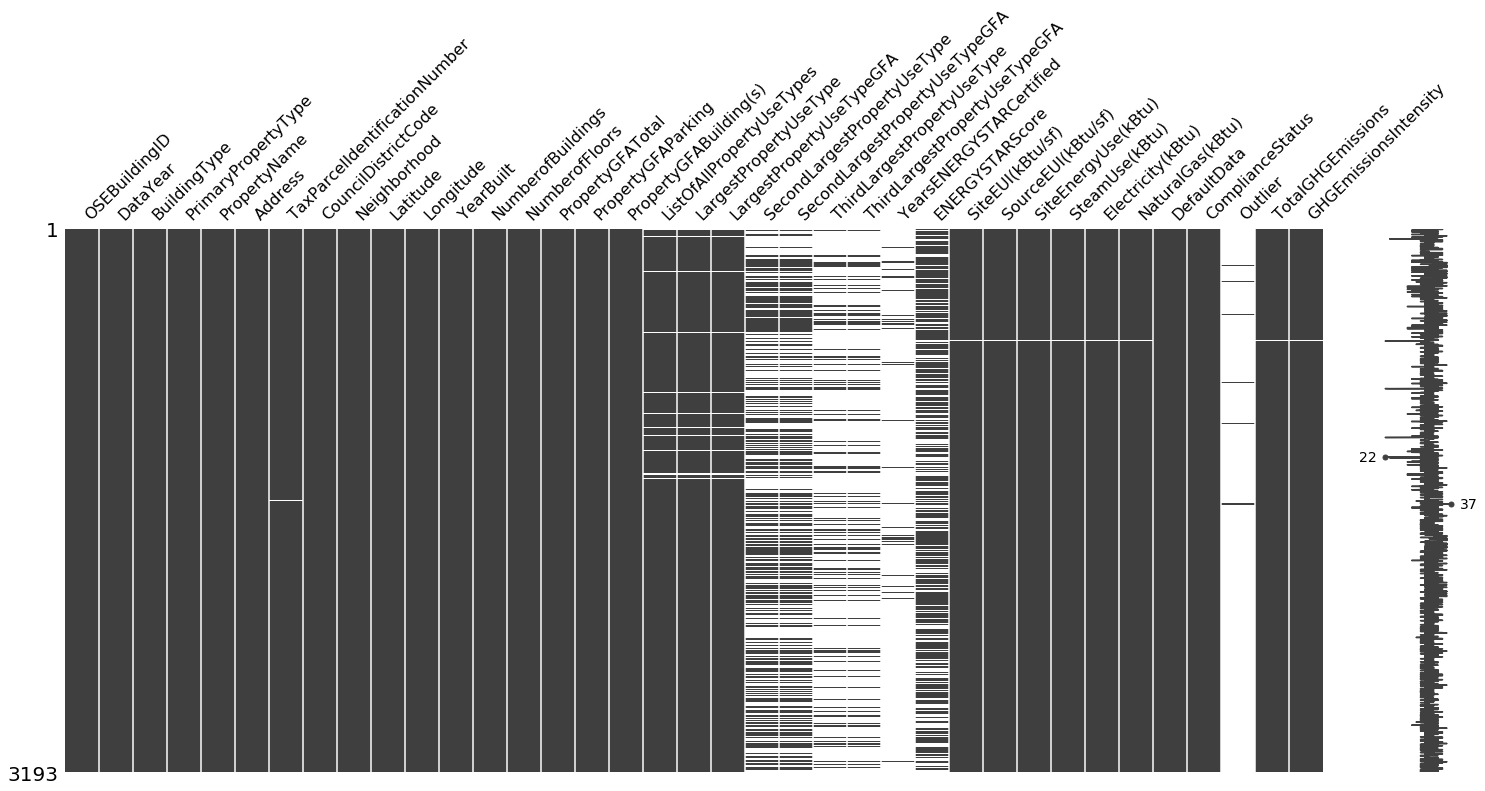

In [57]:
msno.matrix(df)

In [58]:
df.shape

(3193, 37)

In [59]:
df_nan = df.isna().sum().sort_values(ascending=False)
df_nan

Outlier                            3162
YearsENERGYSTARCertified           3007
ThirdLargestPropertyUseType        2515
ThirdLargestPropertyUseTypeGFA     2515
SecondLargestPropertyUseType       1543
SecondLargestPropertyUseTypeGFA    1543
ENERGYSTARScore                    1081
LargestPropertyUseType               69
LargestPropertyUseTypeGFA            69
ListOfAllPropertyUseTypes            61
SiteEUI(kBtu/sf)                      7
SiteEnergyUse(kBtu)                   7
SteamUse(kBtu)                        7
Electricity(kBtu)                     7
NaturalGas(kBtu)                      7
TotalGHGEmissions                     7
SourceEUI(kBtu/sf)                    7
GHGEmissionsIntensity                 7
DefaultData                           1
TaxParcelIdentificationNumber         1
DataYear                              0
CouncilDistrictCode                   0
BuildingType                          0
PrimaryPropertyType                   0
ComplianceStatus                      0


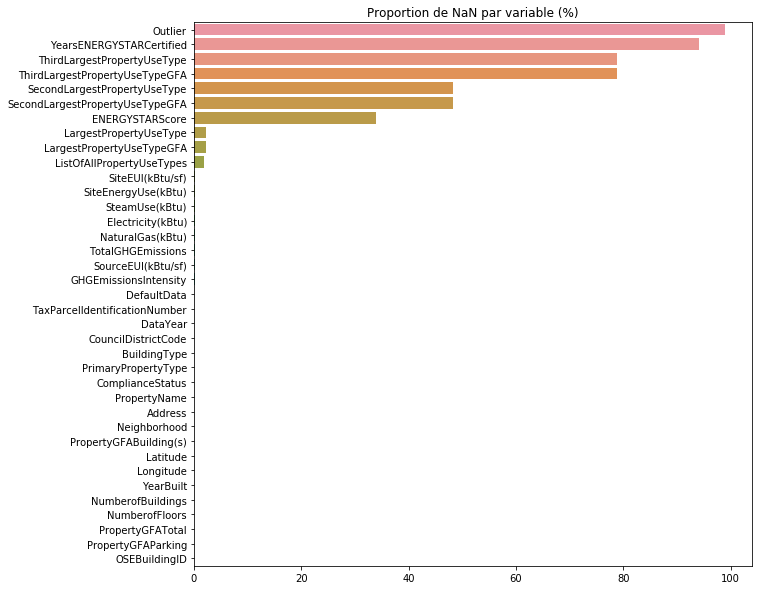

In [60]:
plt.figure(figsize=(10,10))
plt.title('Proportion de NaN par variable (%)')
sns.barplot(x=df_nan.values/df.shape[0]*100, y=df_nan.index)

In [61]:
#Éliminons la variable Outlier qui ne contient que très peu de valeurs :
df.drop(['Outlier'],axis=1)
df.shape

(3193, 37)

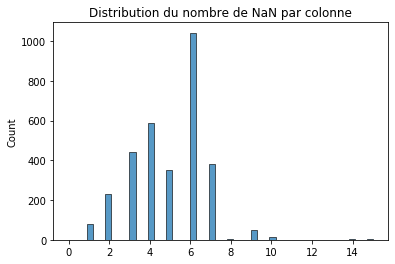

In [62]:
plt.title('Distribution du nombre de NaN par colonne')
sns.histplot(df.isna().sum(axis=1), bins=50)

In [63]:
#Elimination des lignes comportant que des NaNs
df.dropna(how = 'all', axis=0, inplace=True)
df.shape


(3193, 37)

Complétion des NaN de certaines variables par des valeurs Complétion avec 0 :


In [64]:
col_nan_to_zero = ['ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                   'LargestPropertyUseTypeGFA','SteamUse(kBtu)',
                   'Electricity(kBtu)','NaturalGas(kBtu)']
df[col_nan_to_zero] = df[col_nan_to_zero].fillna(0, )

In [65]:
col_no_use = ['LargestPropertyUseType', 'SecondLargestPropertyUseType',
              'ThirdLargestPropertyUseType']
df[col_no_use] = df[col_no_use].fillna('No information')

In [66]:
df[df['LargestPropertyUseType'] == 'No information']

OSEBuildingID  DataYear       BuildingType          PrimaryPropertyType  \
10               15      2015     NonResidential                        Hotel   
14               19      2015     NonResidential                        Hotel   
19               25      2015     NonResidential                        Hotel   
35               46      2015     NonResidential          Distribution Center   
52               67      2015     NonResidential                        Hotel   
160             260      2015  SPS-District K-12            SPS-District K-12   
194             314      2015     NonResidential                        Hotel   
201             322      2015     NonResidential                 Large Office   
204             325      2015     NonResidential                 Retail Store   
233             355      2015     NonResidential                 Large Office   
241             366      2015     NonResidential  Small- and Mid-Sized Office   
251             376      2015     NonResidential                 Large Office   
263             390      2015     NonResidential                 Retail Store   
285             414      2015     NonResidential                 Large Office   
309             439      2015     NonResidential           Mixed Use Property   
320             453      2015     NonResidential  Small- and Mid-Sized Office   
346             487      2015     NonResidential                   Laboratory   
347             488      2015     NonResidential           Mixed Use Property   
355             496      2015     NonResidential        Self-Storage Facility   
364             513      2015     NonResidential  Small- and Mid-Sized Office   
374             523      2015     NonResidential                 Large Office   
379             528      2015     NonResidential                        Other   
395             549      2015     NonResidential  Small- and Mid-Sized Office   
406             560      2015     NonResidential   Non-Refrigerated Warehouse   
465             624      2015     NonResidential   Non-Refrigerated Warehouse   
539             725      2015     NonResidential          Distribution Center   
579             773      2015     NonResidential  Small- and Mid-Sized Office   
586             780      2015     NonResidential                 Large Office   
593             790      2015     NonResidential                        Other   
599             797      2015     NonResidential       Refrigerated Warehouse   
625             832      2015     NonResidential  Small- and Mid-Sized Office   
649           19445      2015     NonResidential           Mixed Use Property   
782           19845      2015     NonResidential                 Retail Store   
1135          20967      2015  SPS-District K-12            SPS-District K-12   
1263          21353      2015     NonResidential  Small- and Mid-Sized Office   
1266          21365      2015     NonResidential               Medical Office   
1296          21447      2015     NonResidential  Small- and Mid-Sized Office   
1447          21792      2015     NonResidential   Non-Refrigerated Warehouse   
1522          22138      2015     NonResidential             Worship Facility   
1527          22163      2015     NonResidential                 Retail Store   
1641          22867      2015     NonResidential  Small- and Mid-Sized Office   
1690          23065      2015     NonResidential               Medical Office   
1775          23311      2015     NonResidential                        Other   
1941          23834      2015     NonResidential   Non-Refrigerated Warehouse   
1942          23835      2015     NonResidential  Small- and Mid-Sized Office   
1943          23836      2015     NonResidential  Small- and Mid-Sized Office   
2002          24035      2015  SPS-District K-12            SPS-District K-12   
2095          24356      2015     NonResidential  Small- and Mid-Sized Office   
2231          24781      2015     Non

In [67]:
df.shape

(3193, 37)

In [68]:
#Le but de notre programme étant de supprimer les relevés coûteux pour les années à venir, nous allons donc exclure toutes les données de relève de notre dataset.
# df = df.drop(['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)'], axis=1)

4.6 Catégorisation et regroupements

In [69]:
columns_to_categorize = ['BuildingType', 'CouncilDistrictCode','Neighborhood']

In [70]:
df[columns_to_categorize] = df[columns_to_categorize].astype('category')

In [71]:
df.shape

(3193, 37)

In [72]:
df.select_dtypes(['object', 'category']).nunique().sort_values(ascending=False)

PropertyName                     3080
Address                          2997
TaxParcelIdentificationNumber    1817
ListOfAllPropertyUseTypes         387
YearsENERGYSTARCertified          113
LargestPropertyUseType             58
SecondLargestPropertyUseType       48
ThirdLargestPropertyUseType        41
PrimaryPropertyType                29
Neighborhood                       13
CouncilDistrictCode                 7
BuildingType                        5
DefaultData                         3
Outlier                             2
ComplianceStatus                    1
dtype: int64

In [73]:
property_use_types_columns = ['LargestPropertyUseType',
                              'PrimaryPropertyType',
                              'SecondLargestPropertyUseType',
                              'ThirdLargestPropertyUseType']

In [74]:
usetype_dict = {'Retail Store' : 'Retail',
                'Supermarket/Grocery Store' : 'Retail',
                'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Retail',
                'Automobile Dealership': 'Retail',
                'Convenience Store without Gas Station': 'Retail',
                'Personal Services': 'Retail',
                'Enclosed Mall': 'Retail',
                'Strip Mall': 'Retail',
                'Wholesale Club/Supercenter': 'Retail',
                'Other - Mall': 'Retail',
                'Supermarket / Grocery Stor': 'Retail',
                
                'Food Sales': 'Leisure',
                'Restaurant' : 'Leisure',
                'Other - Restaurant/Bar' : 'Leisure',
                'Food Service': 'Leisure' ,
                'Worship Facility': 'Leisure',
                'Other - Recreation': 'Leisure',
                'Other - Entertainment/Public Assembly': 'Leisure',
                'Performing Arts': 'Leisure',
                'Bar/Nightclub': 'Leisure',
                'Movie Theater': 'Leisure',
                'Museum': 'Leisure',
                'Social/Meeting Hall': 'Leisure',
                'Fitness Center/Health Club/Gym': 'Leisure',
                'Lifestyle Center ': 'Leisure',
                'Fast Food Restaurant': 'Leisure',
                
                'Multifamily Housing' : 'Hotel/Senior Care/Housing',
                'Other - Lodging/Residential': 'Hotel/Senior Care/Housing',
                'Residence Hall/Dormitory': 'Hotel/Senior Care/Housing',
                'Hotel' : 'Hotel/Senior Care/Housing',
                'Senior Care Community' : 'Hotel/Senior Care/Housing',
                'Residential Care Facility' : 'Hotel/Senior Care/Housing',
                'High-Rise Multifamily': 'Hotel/Senior Care/Housing',
                
                'Medical Office' : 'Health',
                
                'Other - Services' : 'Office',
                'Bank Branch' : 'Office',
                'Financial Office' : 'Office',
                'Other - Public Services': 'Office',

                'K-12 School' : 'Education',
                'Other - Education': 'Education',
                'Vocational School' : 'Education', 
                'Adult Education' : 'Education',
                'Pre-school/Daycare': 'Education',
                'University': 'Education',
                'College/University': 'Education',
                'Library': 'Education'
               }

In [75]:
for column in property_use_types_columns:
    df[column] = df[column].replace(usetype_dict)

In [76]:
for column in df[property_use_types_columns].columns:
    print(df[column].value_counts())
    print('\n')

Office                                                  989
Non-Refrigerated Warehouse                              391
Retail                                                  314
Leisure                                                 309
Hotel/Senior Care/Housing                               254
Education                                               253
Other                                                   195
Distribution Center                                     106
Health                                                   84
No information                                           69
Parking                                                  54
Self-Storage Facility                                    54
Refrigerated Warehouse                                   24
Laboratory                                               22
Hospital (General Medical & Surgical)                    19
Manufacturing/Industrial Plant                           14
Urgent Care/Clinic/Other Outpatient     



Quelques données ont des \n qu'il convient de supprimer.


In [77]:
df.shape

(3193, 37)

In [78]:
df['PrimaryPropertyType'] = df['PrimaryPropertyType'].str.replace('\n','')

In [79]:
for column in df[property_use_types_columns].columns:
    print(df[column].name, ':')
    print(df[column].value_counts(),'\n')

LargestPropertyUseType :
Office                                                  989
Non-Refrigerated Warehouse                              391
Retail                                                  314
Leisure                                                 309
Hotel/Senior Care/Housing                               254
Education                                               253
Other                                                   195
Distribution Center                                     106
Health                                                   84
No information                                           69
Parking                                                  54
Self-Storage Facility                                    54
Refrigerated Warehouse                                   24
Laboratory                                               22
Hospital (General Medical & Surgical)                    19
Manufacturing/Industrial Plant                           14
Urgent Care/Cli

In [80]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
TaxParcelIdentificationNumber         1
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes            61
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA       0
ThirdLargestPropertyUseType           0
ThirdLargestPropertyUseTypeGFA        0
YearsENERGYSTARCertified           3007




Il reste des entrées pour lesquelles nous n'avons pas d'information de consommation d'énergie


In [81]:
df.shape

(3193, 37)

In [82]:
df[df['TotalGHGEmissions'].isna()]

OSEBuildingID  DataYear       BuildingType PrimaryPropertyType  \
62               87      2015  SPS-District K-12           Education   
719           19694      2015  SPS-District K-12           Education   
1358          21570      2015  SPS-District K-12           Education   
1360          21578      2015  SPS-District K-12           Education   
2108          24408      2015  SPS-District K-12           Education   
2381          25361      2015  SPS-District K-12           Education   
2406          25451      2015     NonResidential          Restaurant   

                                        PropertyName              Address  \
62    ARBOR HEIGHTS ELEMENTARY SCHOOL (SPS-DISTRICT)     3701 SW 104TH ST   
719                              MANN (SPS-DISTRICT)     2410 E CHERRY ST   
1358             PINEHURST ELEMENTARY (SPS-DISTRICT)    11530 12TH AVE NE   
1360                   GENESEE SCHOOL (SPS-DISTRICT)   5012 SW GENESEE ST   
2108                   WILSON-PACIFIC (SPS-DISTRICT)       1330 N 90TH ST   
2381               DECATUR ELEMENTARY (SPS-DISTRICT)     7711 43RD AVE NE   
2406                             YALE STREET LANDING  1001 FAIRVIEW AVE N   

     TaxParcelIdentificationNumber CouncilDistrictCode Neighborhood  \
62                      2518400005                   1    SOUTHWEST   
719                      519000290                   3      CENTRAL   
1358                    2044500390                   5        NORTH   
1360                    2095200005                   1    SOUTHWEST   
2108                    3126049064                   5    NORTHWEST   
2381                    6392002430                   4    NORTHEAST   
2406                    4088803010                   3   LAKE UNION   

       Latitude   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
62    47.509354 -122.378222       1948                1.0             2.0   
719   47.608185 -122.300521       1925                1.0             2.0   
1358  47.713343 -122.314590       1950                1.0             1.0   
1360  47.565464 -122.396881       1949                1.0             1.0   
2108  47.695489 -122.340188       1953                1.0             1.0   
2381  47.685590 -122.282590       1961                1.0             1.0   
2406  47.629180 -122.331695       1978                1.0             2.0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
62               53352                   0                   53352   
719              37327                   0                   37327   
1358             34005                   0                   34005   
1360             41221                   0                   41221   
2108            110830                   0                  110830   
2381             43578                   0                   43578   
2406             26519                   0                   26519   

     ListOfAllPropertyUseTypes LargestPropertyUseType  \
62                 K-12 School              Education   
719                K-12 School              Education   
1358               K-12 School              Education   
1360               K-12 School              Education   
2108               K-12 School              Education   
2381               K-12 School              Education   
2406        Office, Restaurant                Leisure   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
62                      53352.0               No information   
719                     41191.0               No information   
1358                    34005.0               No information   
1360                    41221.0               No information   
2108                   110830.0               No information   
2381                    45370.0               No information   
2406                    13592.0                       Office   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
62                        

In [83]:
index_with_nan = df['TotalGHGEmissions'].index[df['TotalGHGEmissions'].isnull()]

df = df.drop(index=index_with_nan)

In [84]:
df[df.TotalGHGEmissions==0]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
44              58      2015  NonResidential                       Retail   
572            765      2015  NonResidential                 Large Office   
513            700      2016  NonResidential  Supermarket / Grocery Store   

                  PropertyName                Address  \
44       CENTURY SQUARE RETAIL           1525 4TH AVE   
572              SEATTLE TOWER           1218 3RD AVE   
513  IUC- Whole Foods Interbay  2001 15th Avenue West   

    TaxParcelIdentificationNumber CouncilDistrictCode           Neighborhood  \
44                     1975700365                   7               DOWNTOWN   
572                    1975200005                   7               DOWNTOWN   
513                    7666201460                   7  MAGNOLIA / QUEEN ANNE   

      Latitude   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
44   47.610764 -122.337677       1920                1.0             2.0   
572  47.607655 -122.335512       1929                1.0            27.0   
513  47.637180 -122.377340       2008                1.0             1.0   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
44              57428                   0                   57428   
572            216571               13320                  203251   
513             57176                   0                   57176   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
44     Non-Refrigerated Warehouse, Other, Retail Store                 Retail   
572        Office, Other - Technology/Science, Parking                 Office   
513  Personal Services (Health/Beauty, Dry Cleaning...                 Retail   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
44                     34617.0   Non-Refrigerated Warehouse   
572                   182604.0                      Parking   
513                    39500.0                       Retail   

     SecondLargestPropertyUseTypeGFA  \
44                           13028.0   
572                          13320.0   
513                          15000.0   

                           ThirdLargestPropertyUseType  \
44                                               Other   
572                         Other - Technology/Science   
513  Personal Services (Health/Beauty, Dry Cleaning...   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
44                           9783.0                      NaN              NaN   
572                          6246.0   2014, 2013, 2012, 2008              NaN   
513                          5500.0                      NaN             31.0   

     SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  \
44           0.000000                 0.0                  0.0   
572          0.000000                 0.0                  0.0   
513        208.800003                 0.0           12525174.0   

     SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu) DefaultData  \
44              0.0                0.0               0.0          No   
572             0.0                0.0               0.0          No   
513             0.0                0.0               0.0       False   

    ComplianceStatus Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
44         Compliant     NaN                0.0                    0.0  
572        Compliant     NaN                0.0                    0.0  
513        Compliant     NaN                0.0                    0.0

In [85]:
df.shape

(3183, 37)

In [86]:


index_a_zero = df['TotalGHGEmissions'].index[df['TotalGHGEmissions']==0]

df = df.drop(index=index_a_zero)



In [87]:
df.shape

(3177, 37)


2. Analyse exploratoire & Feature Engineering

Identification des colonnes inutiles

Nous allons pour commencer supprimer quelques colonnes qui ne seront pas utiles pour notre exploration, notamment nom, adresse, identifiant, etc.


In [88]:
columns_to_drop = ['PropertyName', #similaire à ID
                   'TaxParcelIdentificationNumber', #similaire à ID
                   #'ListOfAllPropertyUseTypes', #donnée figurant dans d'autres colonnes
                   'ComplianceStatus', #infos sur la compétude des données à supprimer
                   'DefaultData', #utilité de la variable inconnue
                   'Address', #non conservé (latitude et longitude préférées)
                   'Outlier', #trop de données manquantes
                   'YearsENERGYSTARCertified' #données incomplètes
                  ]

In [89]:
# En ce qui concerne l'énergie, nous pouvons éliminer également les données surfaciques.

columns_to_drop += ['SiteEUI(kBtu/sf)',
                    'SourceEUI(kBtu/sf)']

In [90]:
#Comme nous avons conservé les deux années, nous avons des lignes en double.
df['OSEBuildingID'].value_counts().head()


1        2
23297    2
23268    2
23265    2
23231    2
Name: OSEBuildingID, dtype: int64

In [91]:
df.groupby("OSEBuildingID").filter(lambda x: len(x) > 1).sort_values(by='OSEBuildingID').head(10)

OSEBuildingID  DataYear    BuildingType        PrimaryPropertyType  \
0              1      2015  NonResidential  Hotel/Senior Care/Housing   
0              1      2016  NonResidential  Hotel/Senior Care/Housing   
1              2      2016  NonResidential  Hotel/Senior Care/Housing   
1              2      2015  NonResidential  Hotel/Senior Care/Housing   
2              3      2015  NonResidential  Hotel/Senior Care/Housing   
2              3      2016  NonResidential  Hotel/Senior Care/Housing   
3              5      2015  NonResidential  Hotel/Senior Care/Housing   
3              5      2016  NonResidential  Hotel/Senior Care/Housing   
4              8      2015  NonResidential  Hotel/Senior Care/Housing   
4              8      2016  NonResidential  Hotel/Senior Care/Housing   

                  PropertyName          Address TaxParcelIdentificationNumber  \
0         MAYFLOWER PARK HOTEL    405 OLIVE WAY                     659000030   
0         Mayflower park hotel    405 Olive way                    0659000030   
1              Paramount Hotel  724 Pine street                    0659000220   
1              PARAMOUNT HOTEL      724 PINE ST                     659000220   
2                 WESTIN HOTEL     1900 5TH AVE                     659000475   
2      5673-The Westin Seattle  1900 5th Avenue                    0659000475   
3                    HOTEL MAX   620 STEWART ST                     659000640   
3                    HOTEL MAX   620 STEWART ST                    0659000640   
4        WARWICK SEATTLE HOTEL    401 LENORA ST                     659000970   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST                    0659000970   

  CouncilDistrictCode Neighborhood   Latitude   Longitude  YearBuilt  \
0                   7     DOWNTOWN  47.612190 -122.337997       1927   
0                   7     DOWNTOWN  47.612200 -122.337990       1927   
1                   7     DOWNTOWN  47.613170 -122.333930       1996   
1                   7     DOWNTOWN  47.613106 -122.333358       1996   
2                   7     DOWNTOWN  47.613349 -122.337699       1969   
2                   7     DOWNTOWN  47.613930 -122.338100       1969   
3                   7     DOWNTOWN  47.614216 -122.336609       1926   
3                   7     DOWNTOWN  47.614120 -122.336640       1926   
4                   7     DOWNTOWN  47.613754 -122.340924       1980   
4                   7     DOWNTOWN  47.613750 -122.340470       1980   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0            12.0             88434                   0   
0                1.0            12.0             88434                   0   
1                1.0            11.0            103566               15064   
1                1.0            11.0            103566               15064   
2                1.0            41.0            961990                   0   
2                1.0            41.0            956110              196718   
3                1.0            10.0             61320                   0   
3                1.0            10.0             61320                   0   
4                1.0            18.0            119890               12460   
4                1.0            18.0            175580               62000   

   PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   88434                          Hotel   
0                   88434                          Hotel   
1                   88502     Hotel, Parking, Restaurant   
1                   88502     Hotel, Parking, Restaurant   
2                  961990  Hotel, Parking, Swimming Pool   
2                  759392                          Hotel   
3                   61320                          Hotel   
3                   61320                          Hotel   
4                  107430  Hotel, Parking, Swimming Pool   
4                  113580  Hotel, Parking, Swimming Poo

In [92]:
col_dbl = ['OSEBuildingID','DataYear','SiteEnergyUse(kBtu)','TotalGHGEmissions']
dbleBat = df[col_dbl].groupby("OSEBuildingID").filter(lambda x: len(x) > 1).sort_values(by='OSEBuildingID')

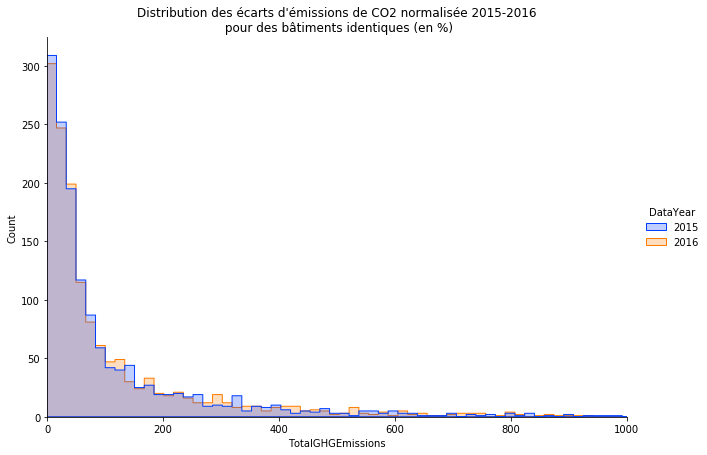

In [93]:
ghg = sns.displot(dbleBat, x='TotalGHGEmissions', hue='DataYear',  
            element="step", palette='bright', height=6, aspect=1.5)
plt.xlim(0,1000)
ghg.set(title="Distribution des écarts d'émissions de CO2 normalisée 2015-2016\n pour des bâtiments identiques (en %)")

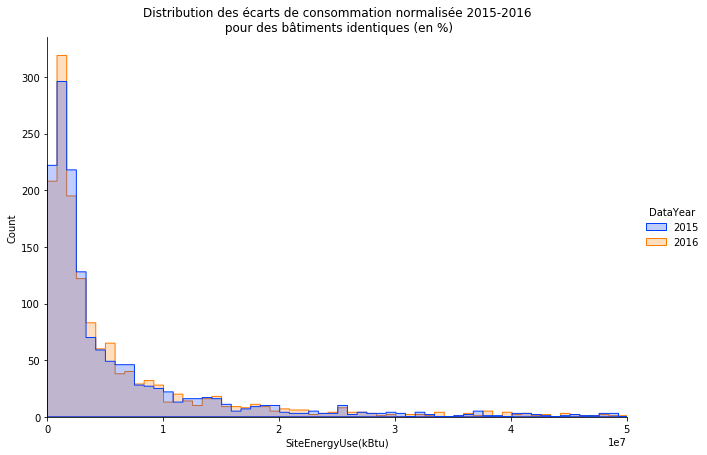

In [94]:
seu=sns.displot(dbleBat, x='SiteEnergyUse(kBtu)', hue='DataYear',  
            element="step", palette='bright', height=6, aspect=1.5)
plt.xlim(0,0.5e8)
seu.set(title="Distribution des écarts de consommation normalisée 2015-2016\n pour des bâtiments identiques (en %)")

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

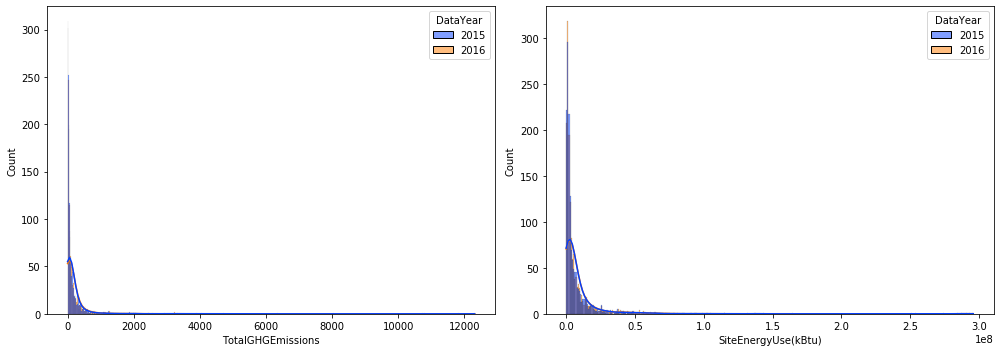

In [95]:
f, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=dbleBat, x="TotalGHGEmissions", hue="DataYear", kde=True, palette='bright', ax=axs[0])
sns.histplot(data=dbleBat, x="SiteEnergyUse(kBtu)", hue="DataYear", kde=True, palette='bright', ax=axs[1])
f.tight_layout()



On observe quelques écarts d'une année à l'autre. Calculons l'écart de consommation énergétique entre les deux années pour chaque bâtiment.


In [96]:
spread = df.groupby("OSEBuildingID").filter(lambda x: len(x) > 1).sort_values(by='OSEBuildingID').groupby('OSEBuildingID')['SiteEnergyUse(kBtu)'].agg(['max','min'])
spread.head()

max         min
OSEBuildingID                        
1               7226362.5   6981428.0
2               8387933.0   8354235.0
3              73130656.0  72587024.0
5              28229320.0   6794584.0
8              14829099.0  14172606.0

In [97]:
spread['min'] = np.true_divide(spread['min'], spread['max'])
spread['max'] = np.true_divide(spread['max'], spread['max'])
spread = spread.diff(axis=1)
spread = spread.multiply(100)
spread = spread.dropna(axis=1)
spread = spread.abs()
spread.rename(columns={'min':'écart'}, inplace=True)
spread.head()

écart
OSEBuildingID           
1               3.389458
2               0.401744
3               0.743371
5              75.930756
8               4.427059

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 6.800000000000011, 'Ecart de consommation 2015/2016 (en %)')

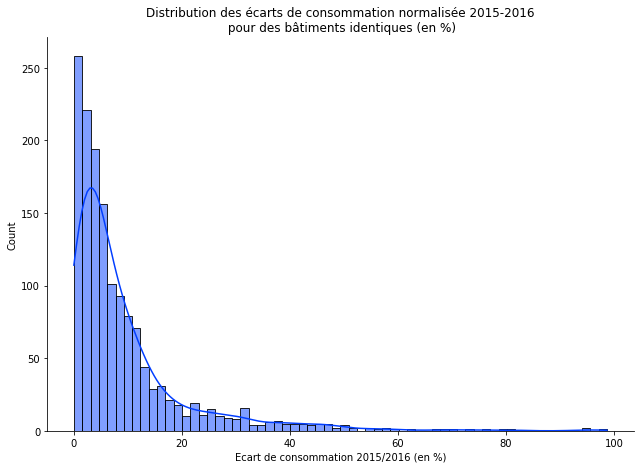

In [98]:
g=sns.displot(spread, kde=True, palette='bright', legend=False, height=6, aspect=1.5)
g.set(title='Distribution des écarts de consommation normalisée 2015-2016\n pour des bâtiments identiques (en %)')
plt.xlabel('Ecart de consommation 2015/2016 (en %)')

In [99]:
print(round(spread.shape[0]*2 / df.shape[0] * 100,0), 
      '% du jeu de données est constitué de bâtiments \ndont on a des informations pour 2015 et 2016')

94.0 % du jeu de données est constitué de bâtiments 
dont on a des informations pour 2015 et 2016


In [100]:
spread.describe().T[['mean', 'min', 'max', '50%', 'std']]

mean       min        max      50%        std
écart  9.242524  0.004618  98.704152  5.30495  11.731953



   - la moyenne d'écart de consommation normalisée est de 10,4 %
   - le minimum d'écart est nul
   - le maximum d'écart est de 100 % (!)
   - la médiane est à 5,4 %
   - la déviation standard est à 15,4 %

    Regardons de plus près les données dont le maximum d'écart est supérieur à la moyenne + 3 x la déviation standard



In [101]:
id_high_spread = spread[spread['écart']>(7.24 + 3*8.57)].reset_index()['OSEBuildingID'].values

In [102]:
id_high_spread

array([    5,   104,   234,   318,   355,   447,   471,   507,   518,
         543,   571,   580,   584,   624,   725,   740,   797,   803,
         811, 19654, 19750, 19855, 19861, 19871, 19895, 20402, 20522,
       20556, 20604, 20613, 20871, 21119, 21216, 21530, 21792, 21920,
       21945, 22438, 22607, 23331, 23397, 23418, 23701, 23716, 23730,
       23835, 23896, 24089, 24102, 24132, 24205, 24356, 24531, 24591,
       24955, 24958, 25250, 25471, 25671, 26596, 26600, 26710, 26849,
       26883, 27184, 27381, 27668, 27799, 28033, 34348, 40348, 49712,
       49784, 49940])

In [103]:
df_high_spread = df[df['OSEBuildingID'].isin(id_high_spread)].sort_values(by='OSEBuildingID')
df_high_spread.head(10)

OSEBuildingID  DataYear        BuildingType         PrimaryPropertyType  \
3                5      2015      NonResidential   Hotel/Senior Care/Housing   
3                5      2016      NonResidential   Hotel/Senior Care/Housing   
70             104      2016  Nonresidential COS                       Other   
70             104      2015  Nonresidential COS                       Other   
146            234      2016  Nonresidential COS                   Warehouse   
145            234      2015  Nonresidential COS  Non-Refrigerated Warehouse   
198            318      2015      NonResidential                       Other   
198            318      2016      NonResidential          Mixed Use Property   
233            355      2015      NonResidential                Large Office   
231            355      2016      NonResidential                Large Office   

                                PropertyName           Address  \
3                                  HOTEL MAX    620 STEWART ST   
3                                  HOTEL MAX    620 STEWART ST   
70                     Bagley Wright Theatre    151 Mercer St.   
70    BAGLEY WRIGHT THEATER - SEATTLE CENTER   305 HARRISON ST   
146                 SCL Roy Street Warehouse        802 Roy St   
145  SEATTLE CITY LIGHT ROY STREET WAREHOUSE      800 ALOHA ST   
198            PIER 54  IVARS ACRES OF CLAMS  1003 ALASKAN WAY   
198                                  Pier 54  1001 Alaskan Way   
233                         901 FIFTH AVENUE       901 5TH AVE   
231                         901 Fifth Avenue  901 Fifth Avenue   

    TaxParcelIdentificationNumber CouncilDistrictCode           Neighborhood  \
3                       659000640                   7               DOWNTOWN   
3                      0659000640                   7               DOWNTOWN   
70                     1985200003                   7  MAGNOLIA / QUEEN ANNE   
70                     1985200003                   7  MAGNOLIA / QUEEN ANNE   
146                    4088803530                   7  MAGNOLIA / QUEEN ANNE   
145                    4088803530                   7  MAGNOLIA / QUEEN ANNE   
198                    7666202495                   7               DOWNTOWN   
198                    7666202495                   7               DOWNTOWN   
233                     942000365                   7               DOWNTOWN   
231                    0942000365                   7               DOWNTOWN   

      Latitude   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
3    47.614216 -122.336609       1926                1.0            10.0   
3    47.614120 -122.336640       1926                1.0            10.0   
70   47.622080 -122.353980       1962                1.0             1.0   
70   47.621241 -122.353432       1962                1.0             1.0   
146  47.625910 -122.340840       1926                1.0             2.0   
145  47.626517 -122.340841       1926                1.0             2.0   
198  47.604119 -122.339602       1900                1.0             1.0   
198  47.604100 -122.339580       1900                1.0             1.0   
233  47.606056 -122.331788       1973                1.0            42.0   
231  47.606160 -122.331650       1973                1.0            42.0   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
3               61320                   0                   61320   
3               61320                   0                   61320   
70              91213                   0                   91213   
70              91213                   0                   91213   
146             50292                   0                   50292   
145             50292                   0                   50292   
198             62900                   0                   62900   
198             62900                   0                   62900   
233            617684              171500                 



On peut constater pour certains bâtiments des changements d'usage. Pour d'autres, nous n'avons pas d'explication; nous allons donc supprimer les valeurs extrêmes.


In [104]:
df = df[~df['OSEBuildingID'].isin(id_high_spread)]
df.shape

(3029, 37)



Suppression des colonnes non utilisées.


In [105]:
for column in columns_to_drop:
    try:
        df.drop(column, axis=1, inplace=True)
    except:
        print('colonne {} absente du jeu de donnée'.format(column))

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029 entries, 0 to 3375
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   OSEBuildingID                    3029 non-null   int64   
 1   DataYear                         3029 non-null   int64   
 2   BuildingType                     3029 non-null   category
 3   PrimaryPropertyType              3029 non-null   object  
 4   CouncilDistrictCode              3029 non-null   category
 5   Neighborhood                     3029 non-null   category
 6   Latitude                         3029 non-null   float64 
 7   Longitude                        3029 non-null   float64 
 8   YearBuilt                        3029 non-null   int64   
 9   NumberofBuildings                3029 non-null   float64 
 10  NumberofFloors                   3029 non-null   float64 
 11  PropertyGFATotal                 3029 non-null   int64   
 12  Proper



2.1 Explorations

2.1.1 Les types de bâtiments


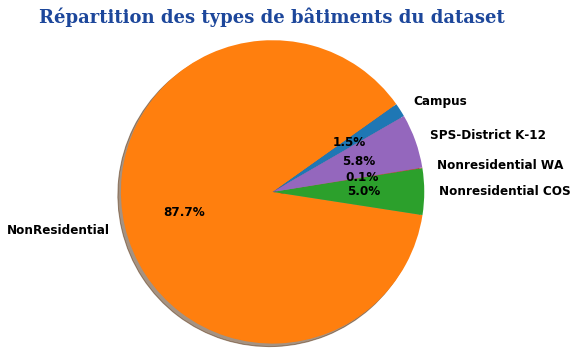

In [107]:
building_type = df.groupby(by='BuildingType')['OSEBuildingID'].nunique()
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(building_type.values, labels=building_type.index, 
       autopct='%1.1f%%', shadow=True, startangle=30,
       textprops=dict(color="black",size=12, weight="bold"))
ax.axis('equal')
ax.set_title("Répartition des types de bâtiments du dataset", fontdict=font_title)
plt.show()



Quels sont ces bâtiments référencés 'NonResidential' et qui représentent la majeure partie des bâtiments.


In [108]:
df.loc[(df['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    537
Other                          356
Large Office                   320
Retail                         206
Hotel/Senior Care/Housing      200
Mixed Use Property             193
Non-Refrigerated Warehouse     165
Warehouse                      163
Leisure                        149
Education                      108
Distribution Center             87
Health                          79
Self-Storage Facility           56
Supermarket / Grocery Store     38
Refrigerated Warehouse          22
Residence Hall                  21
Hospital                        18
Laboratory                      10
Restaurant                       9
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64



Les bureaux de petite et moyenne taille représentent la plus grande part des bâtiments non résidentiels.


In [109]:
df['BuildingType'].value_counts()

NonResidential        2739
Nonresidential COS     142
SPS-District K-12      103
Campus                  44
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [110]:

#il n'y a qu'une seule valeur pour 'Nonresidential WA', ce qui risque de poser des problèmes lors de la séparation du jeu de données; nous allons éliminer cette ligne :



index_to_drop=df[df['BuildingType']=="Nonresidential WA"].index
df.drop(index_to_drop, inplace=True)





2.2. Les années de construction
Nous allons regarder les distribution des années de construction des bâtiments de Seattle :

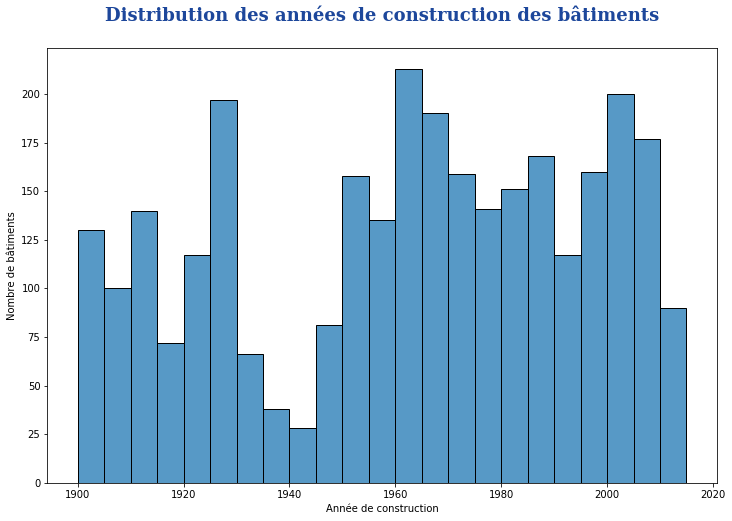

In [111]:


fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df, x='YearBuilt', bins=int((df.YearBuilt.max() - df.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n", fontdict=font_title)
plt.show()





Plus que l'année de construction, il serait intéressant de traiter l'âge des bâtiments pour réduire la dispersion des données et lier l'année des relevés. Nous allons donc créer cette nouvelle variable et supprimer l'année de construction :


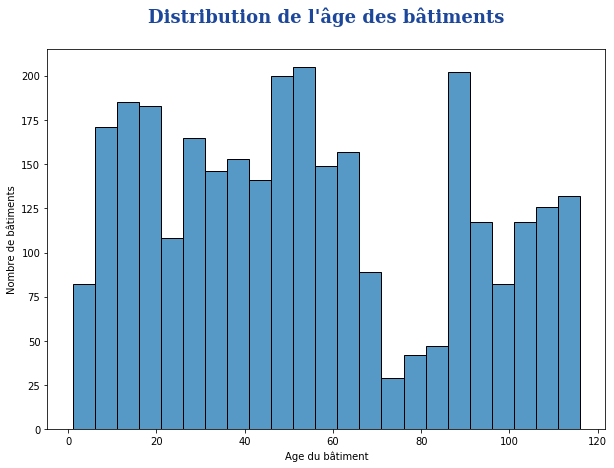

In [112]:
df['BuildingAge'] = df['DataYear'] - df['YearBuilt']
# df.drop('YearBuilt', axis=1, inplace=True)

fig = plt.figure(figsize=(10,7))
ax = sns.histplot(data=df, x='BuildingAge', bins=int((df.BuildingAge.max() - df.BuildingAge.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n", fontdict=font_title)
plt.show()



Examinons la distribution de quelques variables


In [113]:
var_to_hist = ['YearBuilt','PropertyGFATotal','SiteEnergyUse(kBtu)',
               'TotalGHGEmissions','GHGEmissionsIntensity']

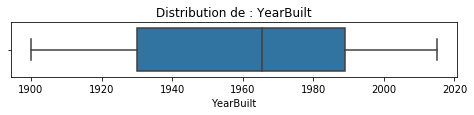

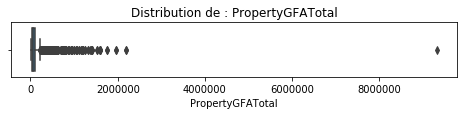

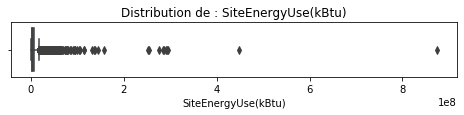

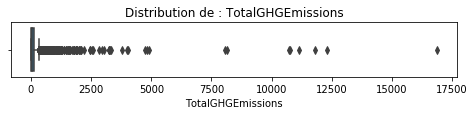

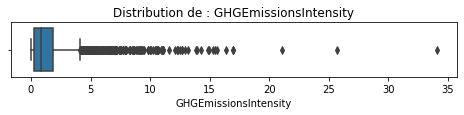

In [114]:
for column in var_to_hist:
    plt.figure(figsize = (8,1))
    
    sns.boxplot(x=df[column])
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()
sns.set(font_scale=1)

In [115]:
for i in df:
    print(i)

OSEBuildingID
DataYear
BuildingType
PrimaryPropertyType
CouncilDistrictCode
Neighborhood
Latitude
Longitude
YearBuilt
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
ListOfAllPropertyUseTypes
LargestPropertyUseType
LargestPropertyUseTypeGFA
SecondLargestPropertyUseType
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseType
ThirdLargestPropertyUseTypeGFA
ENERGYSTARScore
SiteEnergyUse(kBtu)
SteamUse(kBtu)
Electricity(kBtu)
NaturalGas(kBtu)
TotalGHGEmissions
GHGEmissionsIntensity
BuildingAge


In [116]:
cols = ["OSEBuildingID",
"YearBuilt",
"NumberofBuildings",
"NumberofFloors",
"PropertyGFATotal",
"PropertyGFAParking",
"PropertyGFABuilding(s)",
"LargestPropertyUseTypeGFA",
"SecondLargestPropertyUseTypeGFA",
"ENERGYSTARScore",
"Electricity(kBtu)",
"NaturalGas(kBtu)",
"TotalGHGEmissions",
"GHGEmissionsIntensity"]

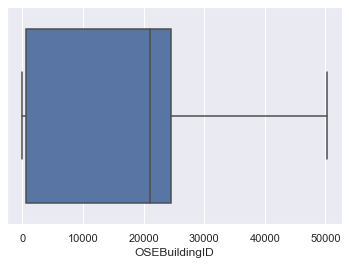

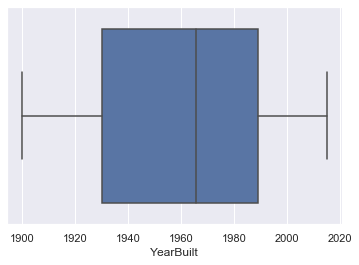

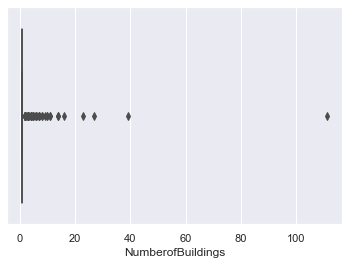

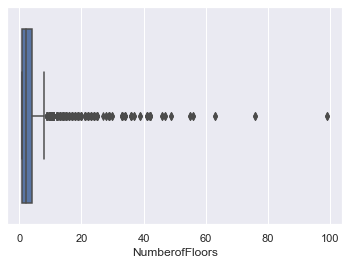

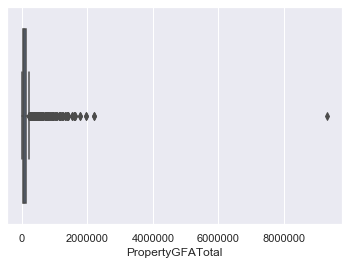

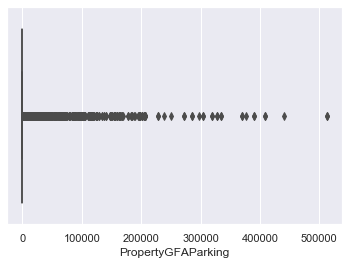

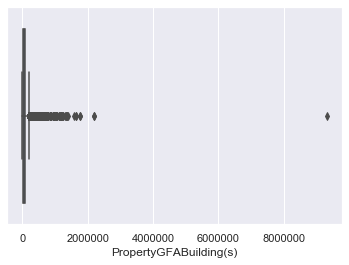

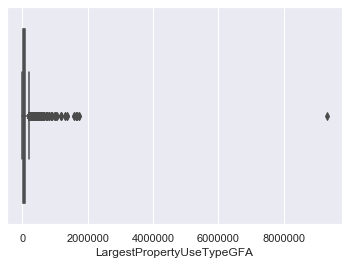

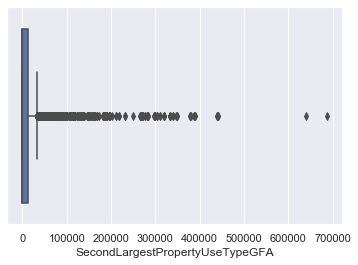

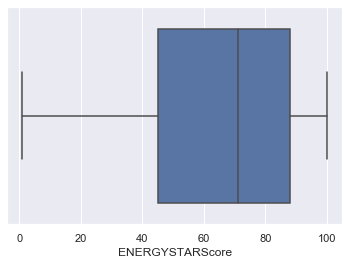

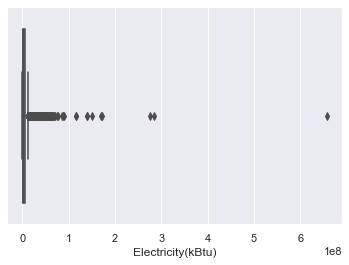

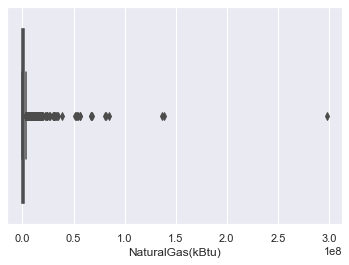

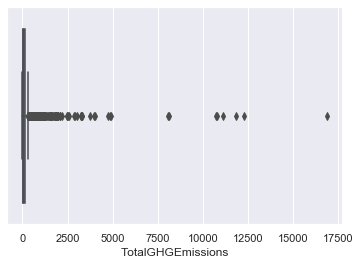

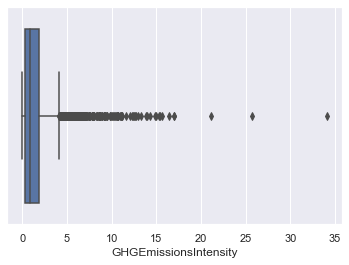

In [117]:
for item in cols:
    sns.boxplot(x = df[item])
    plt.show()



Quelques valeurs sont beaucoup trop éloignées des autres et risquent de nous gêner dans l'analyse; nous allons les éliminer :


In [118]:
df[df['PropertyGFATotal']>9000000]

OSEBuildingID  DataYear BuildingType PrimaryPropertyType  \
3274          49967      2016       Campus           Education   

     CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
3274                   4    NORTHEAST  47.65644 -122.31041       1900   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3274              111.0             1.0           9320156                   0   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
3274                 9320156        College/University              Education   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3274                  9320156.0               No information   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3274                              0.0              No information   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
3274                             0.0              NaN          873923712.0   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
3274      84985240.0        657074389.0               0.0           11140.56   

      GHGEmissionsIntensity  BuildingAge  
3274                    1.2          116

In [119]:


index_to_drop=df[df['PropertyGFATotal']>9000000].index
df.drop(index_to_drop, inplace=True)



In [120]:


df[df['SiteEnergyUse(kBtu)']>6e8]



Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions, GHGEmissionsIntensity, BuildingAge]
Index: []

In [121]:
df['PropertyGFATotal'].describe()

count    3.026000e+03
mean     1.162645e+05
std      1.997195e+05
min      1.128500e+04
25%      2.939550e+04
50%      4.923850e+04
75%      1.079300e+05
max      2.200000e+06
Name: PropertyGFATotal, dtype: float64

In [122]:
#This function allows you to view the distribution 
#of CO2 emissions within the classes of a variable.
def visualisation(variable,df):
    # the_mean=df["GHGEmissions(MetricTonsCO2e)"].mean()
    the_mean=df["TotalGHGEmissions"].mean()
    fig=plt.figure(figsize=[18,7])
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    plt.title("C02 emissions distribution by {}".format(variable),size=16)
    sns.boxplot(x=variable, y="TotalGHGEmissions", data=df,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
    plt.hlines(y=the_mean,xmin=-0.5,xmax=len(df[variable].unique())-0.5,color="#6d788b",ls="--",label="Global mean")

    plt.ylabel(" C02 emissions",size=14)
    plt.xticks(range(0,len(df[variable].unique()))
               ,df[variable].unique(),rotation=90)
    plt.legend()
    plt.grid()
    plt.show()

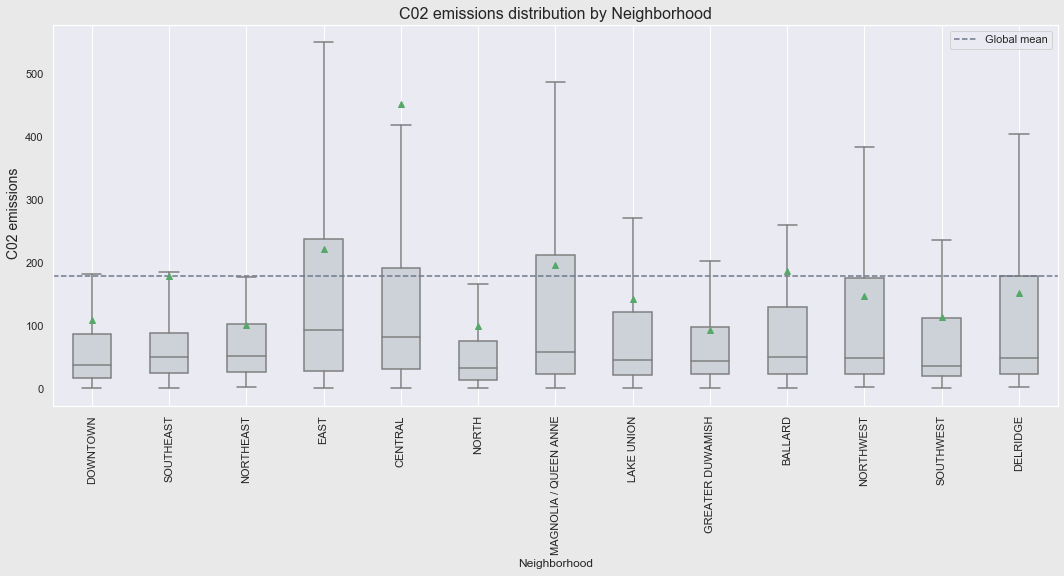

In [123]:
visualisation("Neighborhood",df)

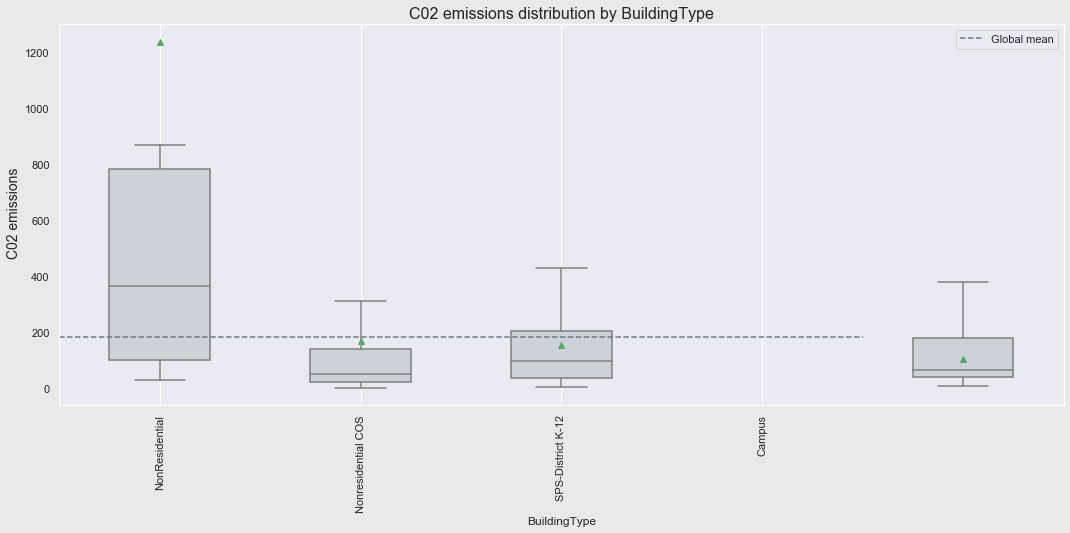

In [124]:
visualisation('BuildingType',df)

2.3. Corrélations linéaires

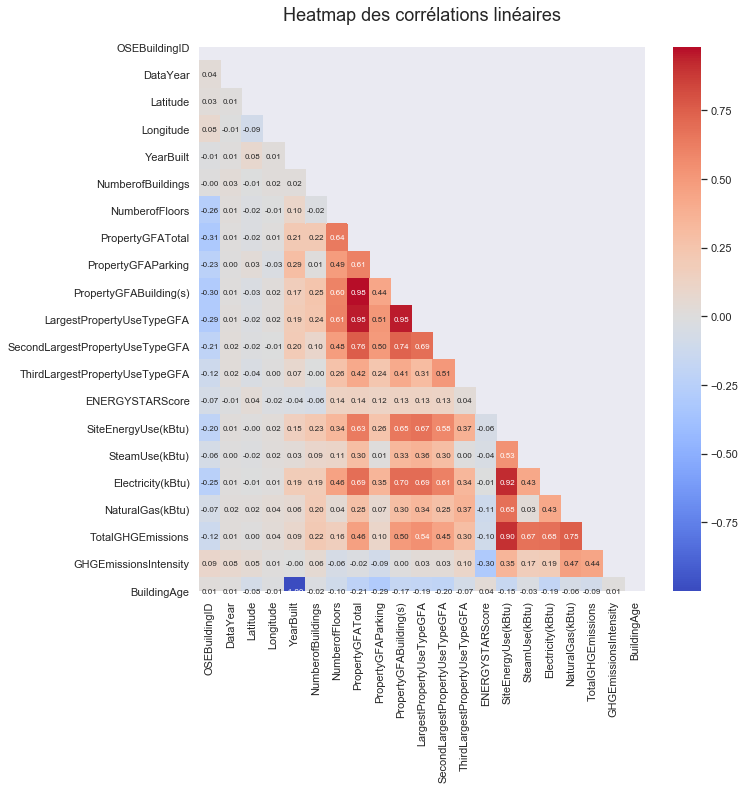

In [125]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontsize = 18)
plt.show()



On peut observer des corrélations importantes entre :

    -PropertyGFATotal et PropertyGFABuilding(s) / LargestPropertyUseTypeGFA
    -PropertyGBABuilding(s) et LargestPropertyUseTypeGFA
    -TotalGHEmissions et SiteEnergyUse(kBtu) / NaturalGas(kBtu)

Pour les variables à prédire 'TotalGHGEmissions' et 'SiteEnergyUse(kBtu)', on remarque des corrélations linéaires très fortes avec les variables de relevés (les consommations) mais également avec le nombre de batiments ou d'étages ainsi que les surfaces au sol.

Les fortes corrélations visibles sur le heatmap peuvent amener des problèmes de colinéarité dans nos futurs modèles. Isolons donc les paires de variables avec des corrélations de Pearson supérieurs à 0.7 :



In [126]:
threshold = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

level_0                          level_1  \
16                 PropertyGFATotal           PropertyGFABuilding(s)   
14        LargestPropertyUseTypeGFA                 PropertyGFATotal   
12           PropertyGFABuilding(s)        LargestPropertyUseTypeGFA   
10              SiteEnergyUse(kBtu)                Electricity(kBtu)   
8               SiteEnergyUse(kBtu)                TotalGHGEmissions   
6   SecondLargestPropertyUseTypeGFA                 PropertyGFATotal   
4                  NaturalGas(kBtu)                TotalGHGEmissions   
2            PropertyGFABuilding(s)  SecondLargestPropertyUseTypeGFA   
0                       BuildingAge                        YearBuilt   

    corr_coeff  
16    0.979071  
14    0.951763  
12    0.949844  
10    0.923665  
8     0.903907  
6     0.760150  
4     0.752026  
2     0.735621  
0    -0.999885



On remarque que les variables suffixées GFA présentent de fortes corrélations avec plusieurs autres variables. Nous allons donc créer de nouvelles variables pour tenter de gommer ces corrélations linéaires :


In [127]:
def split_words(df, column = None):
        list_words = set()
        for word in df[column].str.split(','):
            if isinstance(word, float):
                continue
            list_words = set().union(word, list_words)
        return list(list_words)

list_use_type = split_words(df, 'ListOfAllPropertyUseTypes')
print("Nombre de type d'usages dans la base : {}".format(len(list_use_type)))

Nombre de type d'usages dans la base : 116




Afin de préparer un OneHotEncoder, nous allons créer une variable donnant le nombre total d'usages du bâtiment, puis supprimer la liste complète des usages :


In [128]:
df['TotalUseTypeNumber'] = [str(word).count(",") + 1 for word in df['ListOfAllPropertyUseTypes'].str.split(',')]
df.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)

Nous allons ensuite convertir les différentes surfaces (Buildings et Parking) en pourcentage de la surface totale et nous conserverons uniquement ces 2 variables en supprimant les variables LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA :

In [129]:


gfa_features = search_componant(df, suffix='GFA')
df[['TotalUseTypeNumber'] + gfa_features].head(10)



TotalUseTypeNumber  PropertyGFATotal  PropertyGFAParking  \
0                    1             88434                   0   
1                    3            103566               15064   
2                    3            961990                   0   
4                    3            119890               12460   
5                    1             97288               37198   
6                    1             83008                   0   
7                    1            102761                   0   
8                    1            163984                   0   
10                   1            153163               19279   
11                   1            333176               61161   

    PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                    88434                    88434.0   
1                    88502                    83880.0   
2                   961990                   757243.0   
4                   107430                   123445.0   
5                    60090                    88830.0   
6                    83008                    81352.0   
7                   102761                   102761.0   
8                   163984                   163984.0   
10                  133884                        0.0   
11                  272015                   336640.0   

    SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  
0                               0.0                             0.0  
1                           15064.0                          4622.0  
2                          100000.0                             0.0  
4                           68009.0                             0.0  
5                               0.0                             0.0  
6                               0.0                             0.0  
7                               0.0                             0.0  
8                               0.0                             0.0  
10                              0.0                             0.0  
11                              0.0                             0.0

In [130]:
df.describe()

OSEBuildingID     DataYear     Latitude    Longitude    YearBuilt  \
count    3026.000000  3026.000000  3026.000000  3026.000000  3026.000000   
mean    15809.154329  2015.483807    47.616832  -122.333427  1961.703569   
std     13366.083574     0.499820     0.047556     0.024091    32.918477   
min         1.000000  2015.000000    47.499331  -122.411820  1900.000000   
25%       578.250000  2015.000000    47.588012  -122.343662  1930.000000   
50%     21111.500000  2015.000000    47.612858  -122.333223  1965.500000   
75%     24535.500000  2016.000000    47.649341  -122.322350  1989.000000   
max     50226.000000  2016.000000    47.733870  -122.258795  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count        3026.000000     3026.000000      3.026000e+03   
mean            1.106411        4.267350      1.162645e+05   
std             1.172937        6.737896      1.997195e+05   
min             1.000000        1.000000      1.128500e+04   
25%             1.000000        1.000000      2.939550e+04   
50%             1.000000        2.000000      4.923850e+04   
75%             1.000000        4.000000      1.079300e+05   
max            39.000000       99.000000      2.200000e+06   

       PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count         3026.000000            3.026000e+03               3.026000e+03   
mean         14198.277594            1.020662e+05               9.253879e+04   
std          45191.593007            1.757882e+05               1.627879e+05   
min              0.000000            3.636000e+03               0.000000e+00   
25%              0.000000            2.849400e+04               2.428800e+04   
50%              0.000000            4.725100e+04               4.162400e+04   
75%              0.000000            9.587150e+04               8.992475e+04   
max         512608.000000            2.200000e+06               1.719643e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      3026.000000                     3026.000000   
mean                      19169.421777                     3116.780601   
std                       52249.316141                    16617.696222   
min                           0.000000                        0.000000   
25%                           0.000000                        0.000000   
50%                           0.000000                        0.000000   
75%                       13124.000000                        0.000000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
count      2008.000000         3.026000e+03    3.026000e+03   
mean         63.724602         8.119835e+06    4.592991e+05   
std          28.395480         2.082908e+07    4.979333e+06   
min           1.000000         1.715000e+04    0.000000e+00   
25%          45.000000         1.259818e+06    0.000000e+00   
50%          71.000000         2.661771e+06    0.000000e+00   
75%          88.000000         7.264316e+06    0.000000e+00   
max         100.000000         4.483853e+08    1.349435e+08   

       Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
count       3.026000e+03      3.026000e+03        3026.000000   
mean        5.679086e+06      1.962640e+06         179.278503   
std         1.358439e+07      8.238381e+06         652.504893   
min         0.000000e+00      0.000000e+00           0.120000   
25%         7.489552e+05      0.000000e+00          20.632500   
50%         1.718675e+06      4.902295e+05          50.160000   
75%         5.265868e+06      1.528791e+06         144.725000   
max         2.847263e+08      2.979090e+08       16870.980000   

       GHGEmissionsIntensity  BuildingAge  TotalUseTypeNumber  
count            3026.000000  3026.000000         3026.000000  
mean                1.511666    53.780238            1.914739  
std                 2.195286 

In [131]:
# Calcul des ratios
df['GFABuildingRate'] = (round((df['PropertyGFABuilding(s)'].fillna(0)
                                  /df['PropertyGFATotal'].fillna(0)),5))
df['GFAParkingRate'] = (round((df['PropertyGFAParking'].fillna(0)
                                 /df['PropertyGFATotal'].fillna(0)),5))

# Suppression des variables inutiles
df.drop(['LargestPropertyUseTypeGFA', 
           'SecondLargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType',
           'PropertyGFAParking',
           'PropertyGFABuilding(s)'],
         axis=1, inplace=True)

#On complète les usages de la partie la plus large
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna("Unknown")
df['NumberofFloors'] = df['NumberofFloors'].fillna(1)


In [132]:
#Nous pouvons également calculer la surface moyenne par bâtiment et par étage :



df['GFAPerBuilding'] = round((df['PropertyGFATotal'] / df['NumberofBuildings']),3)
df['GFAPerFloor'] = round((df['PropertyGFATotal'] / df['NumberofFloors']),3)



In [133]:
df.describe()

OSEBuildingID     DataYear     Latitude    Longitude    YearBuilt  \
count    3026.000000  3026.000000  3026.000000  3026.000000  3026.000000   
mean    15809.154329  2015.483807    47.616832  -122.333427  1961.703569   
std     13366.083574     0.499820     0.047556     0.024091    32.918477   
min         1.000000  2015.000000    47.499331  -122.411820  1900.000000   
25%       578.250000  2015.000000    47.588012  -122.343662  1930.000000   
50%     21111.500000  2015.000000    47.612858  -122.333223  1965.500000   
75%     24535.500000  2016.000000    47.649341  -122.322350  1989.000000   
max     50226.000000  2016.000000    47.733870  -122.258795  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFATotal  ENERGYSTARScore  \
count        3026.000000     3026.000000      3.026000e+03      2008.000000   
mean            1.106411        4.267350      1.162645e+05        63.724602   
std             1.172937        6.737896      1.997195e+05        28.395480   
min             1.000000        1.000000      1.128500e+04         1.000000   
25%             1.000000        1.000000      2.939550e+04        45.000000   
50%             1.000000        2.000000      4.923850e+04        71.000000   
75%             1.000000        4.000000      1.079300e+05        88.000000   
max            39.000000       99.000000      2.200000e+06       100.000000   

       SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
count         3.026000e+03    3.026000e+03       3.026000e+03   
mean          8.119835e+06    4.592991e+05       5.679086e+06   
std           2.082908e+07    4.979333e+06       1.358439e+07   
min           1.715000e+04    0.000000e+00       0.000000e+00   
25%           1.259818e+06    0.000000e+00       7.489552e+05   
50%           2.661771e+06    0.000000e+00       1.718675e+06   
75%           7.264316e+06    0.000000e+00       5.265868e+06   
max           4.483853e+08    1.349435e+08       2.847263e+08   

       NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  \
count      3.026000e+03        3026.000000            3026.000000   
mean       1.962640e+06         179.278503               1.511666   
std        8.238381e+06         652.504893               2.195286   
min        0.000000e+00           0.120000               0.000000   
25%        0.000000e+00          20.632500               0.280000   
50%        4.902295e+05          50.160000               0.800000   
75%        1.528791e+06         144.725000               1.820000   
max        2.979090e+08       16870.980000              34.090000   

       BuildingAge  TotalUseTypeNumber  GFABuildingRate  GFAParkingRate  \
count  3026.000000         3026.000000      3026.000000     3026.000000   
mean     53.780238            1.914739         0.935155        0.064845   
std      32.917371            1.212606         0.141474        0.141474   
min       1.000000            1.000000         0.104980        0.000000   
25%      26.000000            1.000000         1.000000        0.000000   
50%      50.000000            2.000000         1.000000        0.000000   
75%      86.000000            2.000000         1.000000        0.000000   
max     116.000000           13.000000         1.000000        0.895020   

       GFAPerBuilding   GFAPerFloor  
count    3.026000e+03  3.026000e+03  
mean     1.112295e+05  3.605980e+04  
std      1.898168e+05  6.231113e+04  
min      4.300000e+03  2.216970e+02  
25%      2.884175e+04  1.309364e+04  
50%      4.828000e+04  2.258400e+04  
75%      1.029825e+05  3.766780e+04  
max      2.200000e+06  1.100000e+06

In [134]:
df.shape

(3026, 26)

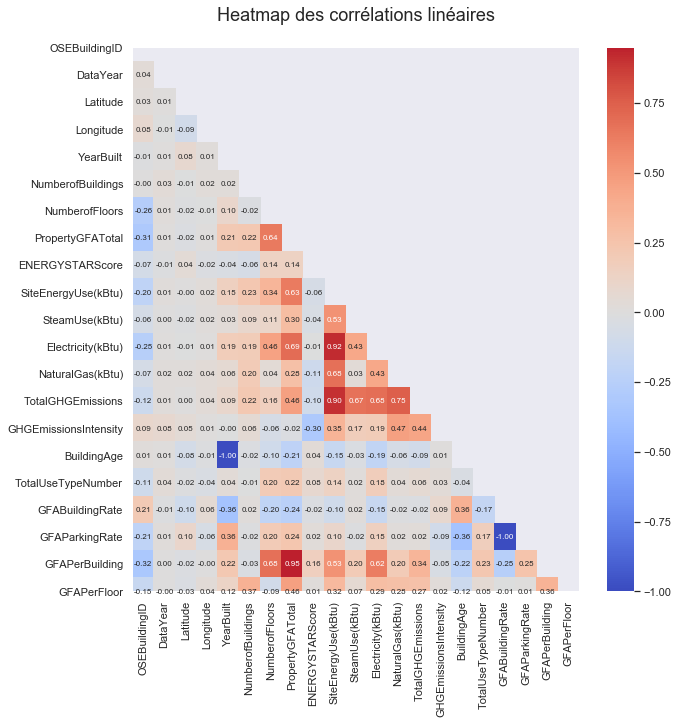

In [135]:
# Vérifions l'impact de ce feature engineering sur la matrice des corrélations linéaires :

corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontsize = 18)
plt.show()


In [136]:
threshold_up = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold_up)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & 
                          (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

level_0              level_1  corr_coeff
10       GFAPerBuilding     PropertyGFATotal    0.948136
8     Electricity(kBtu)  SiteEnergyUse(kBtu)    0.923665
6   SiteEnergyUse(kBtu)    TotalGHGEmissions    0.903907
4     TotalGHGEmissions     NaturalGas(kBtu)    0.752026
2             YearBuilt          BuildingAge   -0.999885
0        GFAParkingRate      GFABuildingRate   -1.000000

2.3. Analyse des variables à prédire

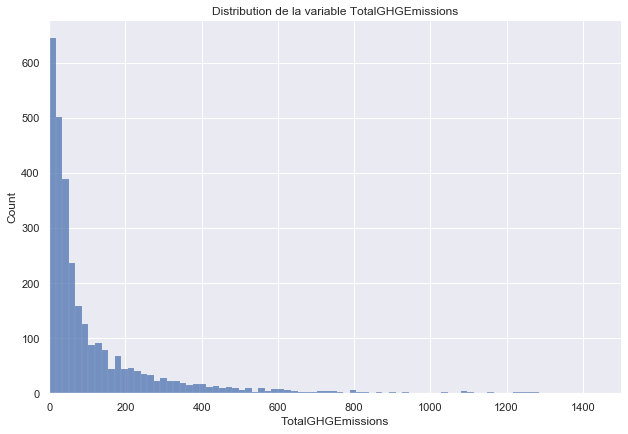

In [137]:
#Pour rappel, les variables à prédire sont 'TotalGHGEmissions' et 'SiteEnergyUse(kBtu)'.

anaghg=sns.displot(df['TotalGHGEmissions'], palette='bright', height=6, aspect=1.5)
plt.xlim(0,1500)
anaghg.set(title="Distribution de la variable TotalGHGEmissions")

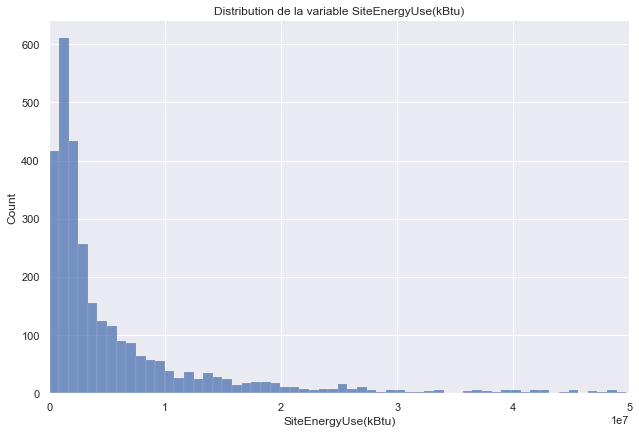

In [138]:
anaseu=sns.displot(df['SiteEnergyUse(kBtu)'], palette='bright', height=6, aspect=1.5)
plt.xlim(0,0.5e8)
anaseu.set(title="Distribution de la variable SiteEnergyUse(kBtu)")


Crétion de nouvelle variables 

In [139]:
#Sauvegardons les données dans un nouveau fichier pour travailler sur les différents modèles de prédiction.

#df.set_index("OSEBuildingID").to_csv("/Users/alexandrejacqueline/Data_Science/P4/building-energy-pred.csv")


In [140]:
import os
os.getcwd()

'/Users/alexandrejacqueline/Data_Science/P4'

In [141]:
df.shape

(3026, 26)